In [1]:
import os
import pandas as pd
import numpy as np
import pickle as pkl
np.set_printoptions(threshold=np.nan)
import matplotlib.pyplot as plt
%matplotlib inline
import string

def softmax(arr):
    return np.exp(arr) / np.sum(np.exp(arr))

# Corpus parameters
K = 2
xi = 1000 # Approximate number of words
T = 20
V = 10

# Initialise the vocabulary
vocab = []
for w in range(V):
    vocab.append(string.ascii_lowercase[w])

prior_dirichlet = np.repeat(1./V, V)
beta = np.random.dirichlet(prior_dirichlet, K)
beta = np.array([[0, 0, 0, 0.3, 0.7, 0, 0, 0, 0, 0], [0, 0, 0.2, 0, 0, 0, 0, 0.3, 0.3, 0.2]])
# print beta[0].sum()
alphas = np.zeros((T, K))
linspace_4pi = np.linspace(0, 4*np.pi, num=T)
alphas[:,0] = np.sin(linspace_4pi) 
alphas[:,1] = np.cos(linspace_4pi) 

corpus = {}
for d in range(T):
    corpus[d] = {}
    N = np.random.poisson(xi)
    for w in range(N):
#         eta = softmax(alphas[d])
#         topic_distrib = np.random.multinomial(1, eta)
        topic_distrib = np.random.multinomial(1, alphas[d])
        z = np.where(topic_distrib == 1)[0][0]
        word_distrib = np.random.multinomial(1, beta[z])
        w = np.where(word_distrib == 1)[0][0]
        w_key = vocab[w]
        if w_key not in corpus[d]:
            corpus[d][w_key] = 0
        corpus[d][w_key] += 1

from preprocessing import preprocess_corpus
count_max = 200.
normalise = False
corpus = preprocess_corpus(corpus, vocab, threshold=count_max, normalise=normalise)
corpus.dump('corpus_test.pkl')

[(0.0, 'a'), (1.0, 'b'), (2.0, 'c'), (3.0, 'd'), (4.0, 'e'), (5.0, 'f'), (6.0, 'g'), (7.0, 'h'), (8.0, 'i'), (9.0, 'j')]


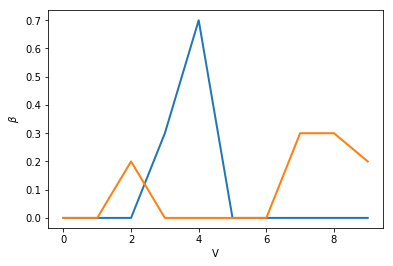

In [2]:
# Plot betas
linspace_V = np.linspace(0, V-1, num=V)
plt.plot(linspace_V, beta[0], linewidth=2)
plt.plot(linspace_V, beta[1], linewidth=2)
print zip(linspace_V, vocab)
plt.xlabel('V')
plt.ylabel(r'$\beta$')

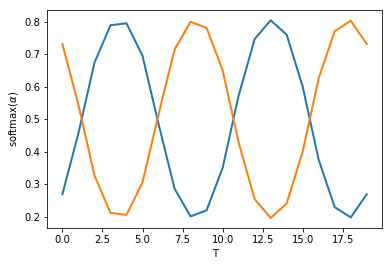

In [3]:
# Plot alphas
linspace_t = np.linspace(0, T-1, num=T)
alphas_softmax = np.zeros(shape=alphas.shape)
for t, alpha_t in enumerate(alphas):
    alphas_softmax[t] = softmax(alpha_t)
plt.plot(linspace_t, alphas_softmax, linewidth=2)
plt.xlabel('T')
plt.ylabel(r'softmax($\alpha$)')
plt.savefig('mu.png')

In [ ]:
from dtm_autoreg import dtm_autoreg

n_it = 1000
var_init = 0.05
var_basic = 0.1
var_prop = 0.5
dtm_autoreg = dtm_autoreg(K=K, n_it=n_it, sigma_0_sq=var_init, sigma_sq=var_basic, 
        delta_sq=var_prop)
dtm_autoreg.beta = beta
dtm_autoreg.fit(corpus)

history_alpha = dtm_autoreg.hist_alpha

Iteration: 10
Total alpha changes: 197
Alpha update rate: 0.4925
Iteration: 20
Total alpha changes: 384
Alpha update rate: 0.4800
Iteration: 30
Total alpha changes: 578
Alpha update rate: 0.4817
Iteration: 40
Total alpha changes: 766
Alpha update rate: 0.4788
Iteration: 50
Total alpha changes: 949
Alpha update rate: 0.4745
Iteration: 60
Total alpha changes: 1134
Alpha update rate: 0.4725
Iteration: 70
Total alpha changes: 1325
Alpha update rate: 0.4732
Iteration: 80
Total alpha changes: 1521
Alpha update rate: 0.4753
Iteration: 90
Total alpha changes: 1721
Alpha update rate: 0.4781
Iteration: 100
Total alpha changes: 1914
Alpha update rate: 0.4785
Iteration: 110
Total alpha changes: 2105
Alpha update rate: 0.4784
Iteration: 120
Total alpha changes: 2296
Alpha update rate: 0.4783
Iteration: 130
Total alpha changes: 2473
Alpha update rate: 0.4756
Iteration: 140
Total alpha changes: 2663
Alpha update rate: 0.4755
Iteration: 150
Total alpha changes: 2860
Alpha update rate: 0.4767
Iteration

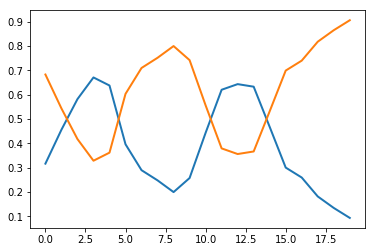

In [19]:
alphas_last_proposed = history_alpha[n_it-1]
alphas_softmax_last_proposed = np.zeros(shape=alphas_last_proposed.shape)
for t, alphas_last_proposed_t in enumerate(alphas_last_proposed):
    alphas_softmax_last_proposed[t] = softmax(alphas_last_proposed_t)
plt.plot(linspace_t, alphas_softmax_last_proposed, linewidth=2)
# plt.plot(linspace_t, history_alpha[iter_count-1], linewidth=2)
# plt.savefig('results/init-%.0E_basic-%.0E_prop-%.0E_it-%d.png' \
#             % (var_init, var_basic, var_prop, n_it))

In [8]:
import plotly.plotly as py
from plotly.graph_objs import Surface
import plotly.graph_objs as go

alphas_softmax_proposed = np.zeros(shape=history_alpha.shape)

diff_min = 10000
idx_min = -1
for it, alpha_it in enumerate(history_alpha):
    for t, alpha_proposed_t in enumerate(alpha_it):
        alphas_softmax_proposed[it][t] = softmax(alpha_proposed_t)
    diff_abs = np.abs(alphas_softmax - alphas_softmax_proposed[it]).sum()
    if diff_abs < diff_min:
        diff_min = diff_abs
        idx_min = it
    
n_alphas = alphas_softmax_proposed.shape[2]
list_alphas = []
for i in range(n_alphas):
    alpha = dict(z = alphas_softmax_proposed[:, :, i], type='surface')
    list_alphas.append(alpha)
fig = go.Figure(data=list_alphas)

py.iplot(fig)

In [66]:
print diff_min
print idx_min

6.91030980045
70


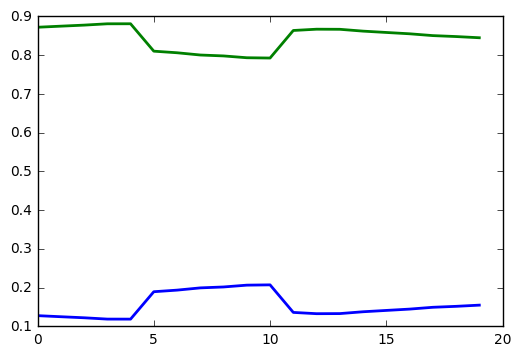

In [57]:
alphas_last_proposed = history_alpha[50]
alphas_softmax_last_proposed = np.zeros(shape=alphas_last_proposed.shape)
for t, alphas_last_proposed_t in enumerate(alphas_last_proposed):
    alphas_softmax_last_proposed[t] = softmax(alphas_last_proposed_t)
plt.plot(linspace_t, alphas_softmax_last_proposed, linewidth=2)
# plt.plot(linspace_t, history_alpha[iter_count-1], linewidth=2)
# plt.savefig('results/var-init-%.1f_var-prop-%.1f_it-total-%d_it-min-%d.png' % (var_init, var_prop, iter_count, idx_min))

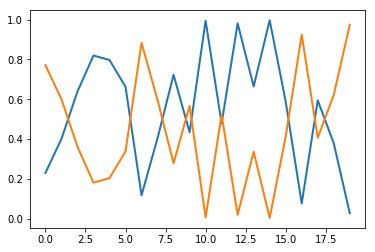

In [30]:
thetas = pd.read_pickle('thetas.pkl')
plt.plot(linspace_t, thetas[499], linewidth=2)
plt.savefig('thetas.png')